# Importing the dependencies

In [1]:
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import plotly.express as px
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Bidirectional,LSTM,Dense,Dropout,SpatialDropout1D,GRU
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

print("Everything imported succesfully")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Everything imported succesfully


In [2]:
# Function for visualizing the results
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Dataset description
An existential problem for any major website today is how to handle toxic and divisive content. Quora wants to tackle this problem head-on to keep their platform a place where users can feel safe sharing their knowledge with the world.

Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:



*   Has a non-neutral tone
*   Has an exaggerated tone to underscore a point about a group of people
*   Is rhetorical and meant to imply a statement about a group of people
*   Is disparaging or inflammatory
*   Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
*   Makes disparaging attacks/insults against a specific person or group of people
Based on an outlandish premise about a group of people
*   Disparages against a characteristic that is not fixable and not measurable
*   Isn't grounded in reality
*   Based on false information, or contains absurd assumptions
*   Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

The training data includes the question that was asked, and whether it was identified as insincere `(target = 1)`. The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

In [3]:
# Loading the data from the csv file into the dataframe
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',compression = 'zip', low_memory = False)

# Exploratory data analysis

In [4]:
print("Shape of the dataframe :",df.shape )

Shape of the dataframe : (1306122, 3)


In [5]:
# Let's see some 5 random rows of the dataframe
df.sample(5)

,qid,question_text,target
650272,7f5cd60c11a2ea7e6588,When will we get the offical release letter on...,0
1202023,eb94501b3f0b499ea0a1,What is adjo.com?,0
255780,321027cd23d951ceb729,How do I find electronic schematics for actual...,0
872766,aaff3de2fcd5e78bc88e,What are the various scopes of Verilog and FPG...,0
212956,29a6ac5c5ddbefb2688d,What are the biggest problems Kolkata faces to...,0


Since the feature `qid` will not be useful for identifical of the insencere discussion, thus we will remove this feature from the dataframe.

In [6]:
# Removing the feature from the dataframe
df.drop(['qid'],axis=1,inplace=True)

In [7]:
# Let's plot pie chart to visualize class distribution
fig = px.pie(df, values=df['target'].value_counts().values, names=['Sincere','Insencere'],width=500, height=400)
fig.show()

In [8]:
def create_balanced_df(df,percentage_to_select):
    
    # Extracting individual dataframes with opposite labels
    Toxic_label_df = df[df['target'] == 1]
    Sincere_label_df = df[df['target'] == 0]

    # Calculating the number of rows to select from sincere dataframe
    num_rows_to_select = int(Sincere_label_df.shape[0] * percentage_to_select)

    # Use the sample function to randomly select rows
    Sincere_label_df = Sincere_label_df.sample(n=num_rows_to_select, random_state=42)
    
    # Concatenate the DataFrames along axis=0
    new_df = pd.concat([Sincere_label_df, Toxic_label_df], axis=0)

    # Shuffle the rows in the concatenated DataFrame and reseting the index (frac = 1) means return all rows
    new_df = new_df.sample(frac=1).reset_index(drop=True)
    return new_df

In [9]:
# Calling function to get the dataframe
df = create_balanced_df(df,0.067)

In [10]:
df.shape

(162905, 2)

# Train test split and creating tensorflow input pipline for data loading and processing
Since we can clearly see that there is a high imbalance in our dataset, so deal with this we will take sample from this data in such a way that the class distribution is well balanced.

In [11]:
# Let's do train test and validation split {80:10:10}
train_df, remaining_df = train_test_split(df,random_state = 1, train_size = 0.8,stratify = df['target'].values)
val_df, test_df = train_test_split(remaining_df,random_state = 1, train_size = 0.5,stratify = remaining_df['target'].values)

print(train_df.shape, test_df.shape, val_df.shape)

(130324, 2) (16291, 2) (16290, 2)


Self Note📝: `tf.device` specify the device on which a particular operation or set of operations should be executed.

In [12]:
# Let's create tf.data.Dataset for model training
train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
val_data = tf.data.Dataset.from_tensor_slices((val_df['question_text'].values, val_df['target'].values))
test_data = tf.data.Dataset.from_tensor_slices((test_df['question_text'].values, test_df['target'].values))

# For optimizing the performance of the input pipeline
train_data = train_data.shuffle(1000).batch(128, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
val_data = val_data.batch(128, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
test_data = test_data.batch(128, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
# Analyzing the performance of the input pipeline for data loading
tfds.benchmark(train_data)


************ Summary ************



  0%|          | 0/1018 [00:00<?, ?it/s]

Examples/sec (First included) 2459.65 ex/sec (total: 1019 ex, 0.41 sec)
Examples/sec (First only) 15.90 ex/sec (total: 1 ex, 0.06 sec)
Examples/sec (First excluded) 2896.89 ex/sec (total: 1018 ex, 0.35 sec)


,duration,num_examples,avg
first+lasts,0.414286,1019,2459.653850
first,0.062875,1,15.904585
lasts,0.351411,1018,2896.892911


In [14]:
tfds.benchmark(val_data)


************ Summary ************



  0%|          | 0/127 [00:00<?, ?it/s]

Examples/sec (First included) 2568.35 ex/sec (total: 128 ex, 0.05 sec)
Examples/sec (First only) 59.41 ex/sec (total: 1 ex, 0.02 sec)
Examples/sec (First excluded) 3847.88 ex/sec (total: 127 ex, 0.03 sec)


,duration,num_examples,avg
first+lasts,0.049838,128,2568.347077
first,0.016832,1,59.409538
lasts,0.033005,127,3847.880032


In [15]:
# Checking the text in batch 1 of 32 texts
for text,label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(
[b'What importance does SRK holds as an Indian in abroad and as well as in India. What is his real power?'
 b'Is it true that Kazakh women prefer to date Russian/Caucasian men?'
 b'Why is track considered the best sport for some people?'
 b'What is the best Joomla website development services?'
 b'If two girls are interlocking their hands together, is that situation a normal closefriend thing or is that a wired thing if that happens on two adult girls in Western countries?'
 b'Is it wrong to feel sexual towards my cat?'
 b'Why do most Muslims hate USA and yet millions of Muslims try their very best to settle down in USA?'
 b'From where SAP should be done?'
 b'How much of a hike does each Indian Army person get to kill one innocent teenager in Kashmir?'
 b"What's the problem with most Americans trying to deny Britain's past achievements and accomplishments?"
 b'How much is 1 trillion?'
 b'Where can I get highly trained technicians in Sydney fire protection?'
 b'Can kevlar lay

# Data processsing

*  Before applying any data preprocessing we will be using the **tf.keras.layers.TextVectorization** layer in TensorFlow which is used for *converting variable-length text sequences* into *fixed-length numerical vector*s. It's commonly used as the first layer in a neural network for processing text data.

*  After using TextVectorization to convert words into integer indices, we will use a separate layer, such as **tf.keras.layers.Embedding**, to perform word embedding. Word embedding is a technique where words are represented as dense vectors in a continuous vector space. The vectors capture semantic relationships between words, allowing the model to learn meaningful representations.

In [16]:
# Defining the text vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=10000,
 standardize = 'lower_and_strip_punctuation',
 output_mode='int',
 output_sequence_length=128)

# Building the vocabulary using the adapt() method
vectorize_layer.adapt(train_data.map(lambda text, label: text))

# Get the vocabulary from the TextVectorization layer
vocabulary = vectorize_layer.get_vocabulary()

In [17]:
# Create a TensorFlow Embedding layer with the weights from Word2Vec
embedding_layer = tf.keras.layers.Embedding(
        input_dim=len(vocabulary),
        output_dim=100,
        input_length=128,
        mask_zero=True)

# Defining Bidirectional LSTM Model
The SpatialDropout1D layer in Keras is a type of dropout layer specifically designed for use with one-dimensional sequence data, such as sequences in natural language processing tasks. It performs dropout, which is a regularization technique, on the sequence data.

In [18]:
def create_model():
    
    # Stacking the layers in the sequential model
    LSTM_model = Sequential()
    LSTM_model.add(vectorize_layer)
    LSTM_model.add(embedding_layer)
    LSTM_model.add(SpatialDropout1D(0.4))
    LSTM_model.add(Bidirectional(LSTM(32)))
    LSTM_model.add(Dense(16, activation='relu'))
    LSTM_model.add(Dense(1,activation='sigmoid'))
    
    return LSTM_model


In [19]:
LSTM_model = create_model()

# Compiling the model (logits = False means we will get probability values rather than raw values)
LSTM_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

                  
num_epochs = 100
early_stop = EarlyStopping(monitor='val_loss', patience=4)
history_LSTM = LSTM_model.fit(train_data,
                     epochs=num_epochs, 
                     validation_data=val_data,
                     callbacks =[early_stop],
                     verbose=1)

Epoch 1/100
1018/1018 [==============================] - 69s 54ms/step - loss: 0.3143 - accuracy: 0.8730 - val_loss: 0.2793 - val_accuracy: 0.8878
Epoch 2/100
1018/1018 [==============================] - 18s 17ms/step - loss: 0.2542 - accuracy: 0.9018 - val_loss: 0.2777 - val_accuracy: 0.8880
Epoch 3/100
1018/1018 [==============================] - 17s 16ms/step - loss: 0.2322 - accuracy: 0.9110 - val_loss: 0.2872 - val_accuracy: 0.8840
Epoch 4/100
1018/1018 [==============================] - 15s 15ms/step - loss: 0.2110 - accuracy: 0.9201 - val_loss: 0.3043 - val_accuracy: 0.8821
Epoch 5/100
1018/1018 [==============================] - 15s 15ms/step - loss: 0.1904 - accuracy: 0.9270 - val_loss: 0.3314 - val_accuracy: 0.8810
Epoch 6/100
1018/1018 [==============================] - 15s 15ms/step - loss: 0.1700 - accuracy: 0.9352 - val_loss: 0.3625 - val_accuracy: 0.8776


In [20]:
test_loss, test_acc = LSTM_model.evaluate(val_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

127/127 [==============================] - 1s 6ms/step - loss: 0.3625 - accuracy: 0.8776
Test Loss: 0.3625212609767914
Test Accuracy: 0.8775836825370789


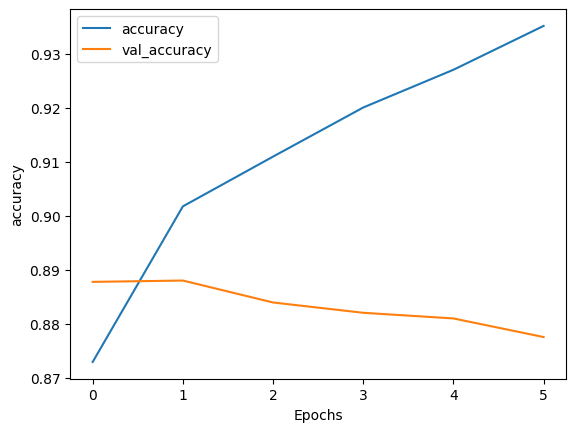

In [21]:
plot_graphs(history_LSTM,'accuracy')

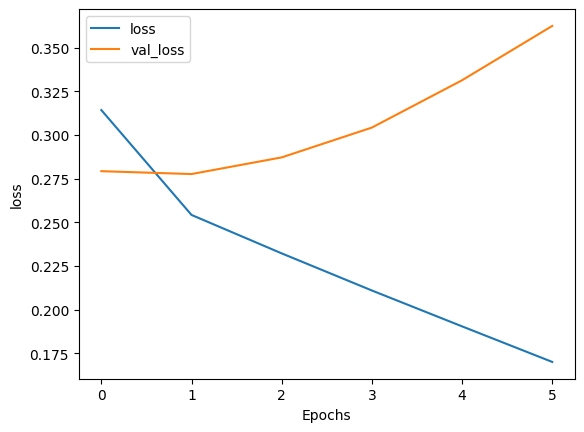

In [22]:
plot_graphs(history_LSTM,'loss')

A Keras model consists of multiple components:

The architecture, or configuration, which specifies what layers the model contain, and how they're connected.
A set of weights values (the "state of the model").
An optimizer (defined by compiling the model).
A set of losses and metrics (defined by compiling the model).
The Keras API saves all of these pieces together in a unified format, marked by the .keras extension. This is a zip archive consisting of the following:

- A JSON-based configuration file (config.json): Records of model, layer, and other trackables' configuration.
- A H5-based state file, such as model.weights.h5 (for the whole model), with directory keys for layers and their weights.
- A metadata file in JSON, storing things such as the current Keras version.

In [23]:
# Saving model as .keras zip folder
LSTM_model.save("BLSTM.keras")

In [24]:
reconstructed_model = keras.models.load_model("/kaggle/working/BLSTM.keras")
reconstructed_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 128)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 128, 100)          1000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 128, 100)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 64)                34048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                        

In [25]:
predictions = reconstructed_model.predict(test_data)
predictions = list(predictions)

# Convert probabilities to binary values using a threshold (e.g., 0.5)
threshold = 0.5
Model_predictions = [1 if prob >= threshold else 0 for prob in predictions]

127/127 [==============================] - 3s 5ms/step


In [26]:
# Extracting labels from the entire dataset, you can use the `unbatch` method
Actual_labels = list(test_data.unbatch().map(lambda features, labels: labels).as_numpy_iterator())

# Model evaluation

In [27]:
# Accuracy
accuracy = accuracy_score(Actual_labels, Model_predictions)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(Actual_labels, Model_predictions)
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(Actual_labels, Model_predictions)
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(Actual_labels, Model_predictions)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8830
Precision: 0.8711
Recall: 0.8970
F1 Score: 0.8838
